# Self-Driving Car Engineer Nanodegree

## Project 1: Finding Lane Lines on the Road
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

In addition to implementing code, there is a brief writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) that can be used to guide the writing process. Completing both the code in the Ipython notebook and the writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/322/view) for this project.

---

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, see [this forum post](https://carnd-forums.udacity.com/cq/viewquestion.action?spaceKey=CAR&id=29496372&questionTitle=finding-lanes---import-cv2-fails-even-though-python-in-the-terminal-window-has-no-problem-with-import-cv2) for more troubleshooting tips.**  

## Import Packages

In [19]:
#importing some useful packages
%reset -f
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


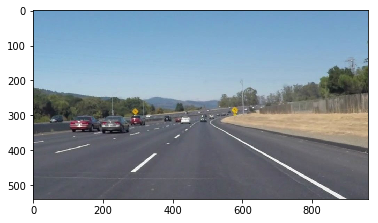

In [20]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteCurve.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

## Ideas for Lane Detection Pipeline

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

## Helper Functions

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [21]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image
            
def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

## Test Images

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

## Build a Lane Finding Pipeline

Build the pipeline and run your solution on all test_images. Make copies into the `test_images_output` directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

### New Helper Functions 

In [22]:
# Modify draw_lines() to draw blank background 
# and to take lines as tuples of two points
def draw_lines(lines, image_shape, color=[255, 0, 0], thickness=2):
    lane = np.zeros((image_shape[0], image_shape[1], 3), dtype=np.uint8)
    for line in lines:
        cv2.line(lane, line[0], line[1], color, thickness)
    return lane

# Transform Hough line segments into two end-points for single lane (right or left) 
def lane_line(image, hough_lines, side, lane_distance):
    """
    Inputs:  initial image; output of cv2.HoughLinesP, and side = "right" or "left"
    Outputs: single lane line: (x1,y1),(x2,y2)
    """
    # Get grid max points
    x_max = image.shape[1] - 1
    y_max = image.shape[0] - 1

    # Separate Hough lines into lane side by their slope 
    if side == 'left':
        one_side_lines = np.array([(x1,y1,x2,y2) for line in hough_lines 
                                                    for x1,y1,x2,y2 in line
                                                    if (x1 < 0.5*image.shape[1] and x2 < 0.5*image.shape[1])
                                                    if ((y2 - y1)/(x2 - x1) < 0)])
    elif side == 'right':
        one_side_lines = np.array([(x1,y1,x2,y2) for line in hough_lines 
                                        for x1,y1,x2,y2 in line
                                        if (x1 > 0.5*image.shape[1] and x2 > 0.5*image.shape[1])
                                        if ((y2 - y1)/(x2 - x1) > 0)])

    # Calculate median slope and median intercept for single-side Hough lines
    slope = np.median([(y2 - y1)/(x2 - x1) for x1,y1,x2,y2 in one_side_lines])
    b = int(np.median([y1 - x1*(y2 - y1)/(x2 - x1) for x1,y1,x2,y2 in one_side_lines]))

    # Derive lane line origin (i.e. near_point) from median slope and median intercept 
    origin = int((y_max - b) / slope)        
    near_point = (origin, y_max)

    # Derive lane line end-point (i.e. far_point) from origin, median slope, 
    # and (input) lane_distance
    if side == 'left':
        far_point = (int(origin + abs(lane_distance / slope)),
                      int(y_max - lane_distance))
    elif side == 'right':
        far_point = (int(origin - abs(lane_distance / slope)),
                      int(y_max - lane_distance))

    # Return lane line end-points    
    return near_point, far_point

### Pipeline to draw lane lines on test images

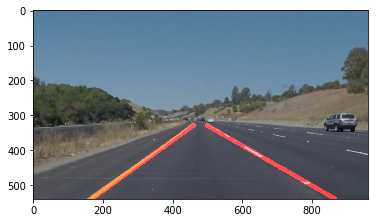

In [23]:
import os

# Read image directory name and import file
test_images = os.listdir("test_images/")
name = test_images[0] 
"""comment line above, uncomment line below, 
and indent remaining code to loop through all test images"""
#for name in test_images: 
image = mpimg.imread('test_images/' + name)

# Get image and grid sizes
imshape = image.shape
x_max = imshape[1] - 1
y_max = imshape[0] - 1

# Grayscale the image and apply Gaussian smoothing
gray = grayscale(image)
kernel_size = 5
blur_gray = gaussian_blur(gray, kernel_size)

# Apply Canny transform to get raw edges
low_threshold = 35
high_threshold = 70
edges = canny(blur_gray, low_threshold, high_threshold) 

# Create masked image of edges
vertices = np.array([[(0.50*x_max, 0.55*y_max),(0.10*x_max, y_max), 
                        (0.90*x_max, y_max), (0.50*x_max, 0.55*y_max)]], 
                        dtype=np.int32)
masked_edges = region_of_interest(edges, vertices)

# Apply Hough transform
# Get raw Hough lines
rho = 1              # distance resolution in pixels
theta = 1*np.pi/180  # angular resolution in radians 
threshold = 4        # minimum number of votes (intersections in Hough grid cell)
min_line_len = 25    # in pixels
max_line_gap = 15    # in pixels   
hough_lines = cv2.HoughLinesP(masked_edges, rho, theta, threshold, np.array([]),
                            min_line_len, max_line_gap)

# Apply new helper function -- lane_line() --
# to get end-points for each lane line
lane_distance = 210
left_line = lane_line(image, hough_lines, 'left', lane_distance)    
right_line = lane_line(image, hough_lines, 'right', lane_distance)
lane_lines = left_line, right_line

# Draw lane on blank image (all black)
lane = draw_lines(lane_lines, imshape, color=[255, 0, 0], thickness=12)

# Add lanes image to original image
lane_image = weighted_img(lane, image, α=0.8, β=1., λ=0.)

# Plot processed image
plt.imshow(lane_image)

# Save processed image to output folder
mpimg.imsave('test_images_output/' + 'processed_' + name, lane_image)

# Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an `import error` when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt. Also, check out [this forum post](https://carnd-forums.udacity.com/questions/22677062/answers/22677109) for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://carnd-forums.udacity.com/display/CAR/questions/26218840/import-videofileclip-error) for more troubleshooting tips across operating systems.**

In [24]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [25]:
def process_image(image):
    
    # Get image and grid sizes
    imshape = image.shape
    x_max = imshape[1] - 1
    y_max = imshape[0] - 1

    # Grayscale the image and apply Gaussian smoothing
    gray = grayscale(image)
    kernel_size = 5
    blur_gray = gaussian_blur(gray, kernel_size)

    # Apply Canny transform to get raw edges
    low_threshold = 35
    high_threshold = 70
    edges = canny(blur_gray, low_threshold, high_threshold) 

    # Create masked image of edges
    vertices = np.array([[(0.50*x_max, 0.55*y_max),(0.10*x_max, y_max), 
                            (0.90*x_max, y_max), (0.50*x_max, 0.55*y_max)]], 
                            dtype=np.int32)
    masked_edges = region_of_interest(edges, vertices)

    # Apply Hough transform
    # Get raw Hough lines
    rho = 1              # distance resolution in pixels
    theta = 1*np.pi/180  # angular resolution in radians 
    threshold = 4        # minimum number of votes (intersections in Hough grid cell)
    min_line_len = 25    # in pixels
    max_line_gap = 15    # in pixels   
    hough_lines = cv2.HoughLinesP(masked_edges, rho, theta, threshold, np.array([]),
                                min_line_len, max_line_gap)

    # Apply new helper function -- lane_line() --
    # to get end-points for each lane line
    lane_distance = 210
    left_line = lane_line(image, hough_lines, 'left', lane_distance)    
    right_line = lane_line(image, hough_lines, 'right', lane_distance)
    lane_lines = left_line, right_line

    # Draw lane on blank image (all black)
    lane = draw_lines(lane_lines, imshape, color=[255, 0, 0], thickness=12)

    # Add lanes image to original image
    lane_image = weighted_img(lane, image, α=0.8, β=1., λ=0.)
    
    return lane_image

Let's try the one with the solid white lane on the right first ...

In [37]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4") #.subclip(0,5) #test
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)


                                                             

                                                        


                                                                
t:  86%|████████▌ | 190/221 [1:47:05<00:00, 65.60it/s, now=None]

t:  86%|████████▌ | 190/221 [36:48<00:00, 51.00it/s, now=None]


t:  86%|████████▌ | 190/221 [1:50:06<00:00, 61.52it/s, now=None]A
                                                             

                                                        


                                                                
t:  86%|████████▌ | 190/221 [1:47:05<00:00, 65.60it/s, now=None]

t:  86%|████████▌ | 190/221 [36:48<00:00, 51.00it/s, now=None]


t:  86%|████████▌ | 190/221 [1:50:06<00:00, 61.52it/s, now=None]A



t:   0%|          | 0/221 [00:00<?, ?it/s, now=None]



t:   5%|▍         | 10/221 [00:00<00:02, 98.21it/s, now=None]

Moviepy - Building video test_videos_output/solidWhiteRight.mp4.
Moviepy - Writing video test_videos_output/solidWhiteRight.mp4







t:  10%|▉         | 22/221 [00:00<00:01, 102.37it/s, now=None]



t:  15%|█▌        | 34/221 [00:00<00:01, 106.15it/s, now=None]



t:  21%|██        | 46/221 [00:00<00:01, 109.12it/s, now=None]



t:  25%|██▍       | 55/221 [00:00<00:01, 85.03it/s, now=None] 



t:  29%|██▊       | 63/221 [00:00<00:01, 79.28it/s, now=None]



t:  32%|███▏      | 71/221 [00:00<00:01, 77.39it/s, now=None]



t:  36%|███▌      | 79/221 [00:00<00:02, 68.10it/s, now=None]



t:  39%|███▉      | 86/221 [00:01<00:02, 64.01it/s, now=None]



t:  42%|████▏     | 93/221 [00:01<00:02, 63.10it/s, now=None]



t:  45%|████▌     | 100/221 [00:01<00:01, 64.21it/s, now=None]



t:  48%|████▊     | 107/221 [00:01<00:01, 64.24it/s, now=None]



t:  52%|█████▏    | 114/221 [00:01<00:01, 64.17it/s, now=None]



t:  55%|█████▍    | 121/221 [00:01<00:01, 64.91it/s, now=None]



t:  58%|█████▊    | 128/221 [00:01<00:01, 63.13it/s, now=None]



t:  61%|██████    | 135/221 [00:01<00:01, 60.22it/s, now=None]



t:  64%|███

ValueError: cannot convert float NaN to integer

Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [38]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))





t:  86%|████████▌ | 190/221 [00:15<00:00, 60.36it/s, now=None]

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [39]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4') #.subclip(0,5) #test
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)


                                                             

                                                        


                                                                



                                                  
t:  86%|████████▌ | 190/221 [1:47:37<00:00, 65.60it/s, now=None]

t:  86%|████████▌ | 190/221 [37:20<00:00, 51.00it/s, now=None]


t:  86%|████████▌ | 190/221 [1:50:38<00:00, 61.52it/s, now=None]A



t:  86%|████████▌ | 190/221 [00:32<00:00, 60.36it/s, now=None]
                                                             

                                                        


                                                                



                                                  
t:  86%|████████▌ | 190/221 [1:47:38<00:00, 65.60it/s, now=None]

t:  86%|████████▌ | 190/221 [37:20<00:00, 51.00it/s, now=None]


t:  86%|████████▌ | 190/221 [1:50:38<00:00, 61.52it/s, now=None]A



t:  86%|████████▌ | 190/221 [00:32<00:00, 60.36it/s, n

Moviepy - Building video test_videos_output/solidYellowLeft.mp4.
Moviepy - Writing video test_videos_output/solidYellowLeft.mp4








t:   3%|▎         | 21/681 [00:00<00:06, 97.65it/s, now=None]




t:   5%|▍         | 33/681 [00:00<00:06, 101.69it/s, now=None]




t:   6%|▋         | 44/681 [00:00<00:06, 103.36it/s, now=None]




t:   8%|▊         | 53/681 [00:00<00:07, 79.09it/s, now=None] 




t:   9%|▉         | 61/681 [00:00<00:08, 74.58it/s, now=None]




t:  10%|█         | 69/681 [00:00<00:09, 66.26it/s, now=None]




t:  11%|█         | 76/681 [00:00<00:09, 66.30it/s, now=None]




t:  12%|█▏        | 83/681 [00:01<00:09, 62.60it/s, now=None]




t:  13%|█▎        | 90/681 [00:01<00:09, 62.61it/s, now=None]




t:  14%|█▍        | 97/681 [00:01<00:09, 59.17it/s, now=None]




t:  15%|█▌        | 103/681 [00:01<00:10, 57.44it/s, now=None]




t:  16%|█▌        | 109/681 [00:01<00:10, 54.49it/s, now=None]




t:  17%|█▋        | 115/681 [00:01<00:10, 54.37it/s, now=None]




t:  18%|█▊        | 122/681 [00:01<00:09, 56.78it/s, now=None]




t:  19%|█▉        | 130/681 [00:01<00:09, 59.81it/s, now=None]



Moviepy - Done !
Moviepy - video ready test_videos_output/solidYellowLeft.mp4
CPU times: user 9.13 s, sys: 1.3 s, total: 10.4 s
Wall time: 11.5 s


In [40]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [41]:
challenge_output = 'test_videos_output/challenge.mp4'
clip3 = VideoFileClip('test_videos/challenge.mp4') #.subclip(0,5) #test
challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)


                                                             

                                                        


                                                                



                                                  
t:  86%|████████▌ | 190/221 [1:49:24<00:00, 65.60it/s, now=None]

t:  86%|████████▌ | 190/221 [39:07<00:00, 51.00it/s, now=None]


t:  86%|████████▌ | 190/221 [1:52:25<00:00, 61.52it/s, now=None]A



t:  86%|████████▌ | 190/221 [02:19<00:00, 60.36it/s, now=None]
                                                             

                                                        


                                                                



                                                  
t:  86%|████████▌ | 190/221 [1:49:24<00:00, 65.60it/s, now=None]

t:  86%|████████▌ | 190/221 [39:07<00:00, 51.00it/s, now=None]


t:  86%|████████▌ | 190/221 [1:52:25<00:00, 61.52it/s, now=None]A



t:  86%|████████▌ | 190/221 [02:19<00:00, 60.36it/s, n

Moviepy - Building video test_videos_output/challenge.mp4.
Moviepy - Writing video test_videos_output/challenge.mp4








t:   4%|▍         | 10/251 [00:00<00:05, 46.06it/s, now=None]




t:   6%|▌         | 15/251 [00:00<00:05, 46.32it/s, now=None]




t:   8%|▊         | 20/251 [00:00<00:04, 47.05it/s, now=None]




t:  10%|█         | 26/251 [00:00<00:04, 48.09it/s, now=None]




t:  12%|█▏        | 31/251 [00:00<00:04, 48.10it/s, now=None]




t:  14%|█▍        | 36/251 [00:00<00:04, 47.24it/s, now=None]




t:  16%|█▋        | 41/251 [00:00<00:04, 46.86it/s, now=None]




t:  18%|█▊        | 46/251 [00:00<00:04, 46.70it/s, now=None]




t:  20%|██        | 51/251 [00:01<00:05, 35.92it/s, now=None]




t:  22%|██▏       | 55/251 [00:01<00:06, 32.16it/s, now=None]




t:  24%|██▎       | 59/251 [00:01<00:06, 28.69it/s, now=None]




t:  25%|██▌       | 63/251 [00:01<00:06, 29.30it/s, now=None]




t:  27%|██▋       | 67/251 [00:01<00:06, 26.48it/s, now=None]




t:  28%|██▊       | 70/251 [00:01<00:07, 25.69it/s, now=None]




t:  29%|██▉       | 73/251 [00:02<00:07, 24.20it/s, now=None]




t:  3

Moviepy - Done !
Moviepy - video ready test_videos_output/challenge.mp4
CPU times: user 7.98 s, sys: 1.36 s, total: 9.34 s
Wall time: 10.9 s


In [42]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))